**Project Multiclass fish image classification**

**Title**: Multiclass Fish Image Classification

**Domain**: Image Classification (using CNN + Transfer Learning)

**Tech Stack**: Python, TensorFlow/Keras, Streamlit

**Goal**:
- Train both a custom CNN (Convolution Neural Network) and five pre-trained models.
- Evaluate and compare their performance.
- Deploy the best model using Streamlit to classify fish species from images.

# First lets import the necessary libraries for this project

In [64]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from cnn_model import build_custom_cnn, train_custom_cnn
from data_loader import create_data_generators
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from vgg16_model import build_vgg16_model, train_vgg16_model

#Since we are working on Image classification and not a excel data set. We will need to extract the directory structure
- Extracting just the directory structure first to understand the number of classes.
- This will tell us:
- Number of fish categories (i.e., folders).
- Approx. number of images per class.

In [21]:
dataset_path_1 = r"C:\Users\shail_u9zs758\Downloads\Dataset\images.cv_jzk6llhf18tm3k0kyttxz\data\val"  
dataset_path_2 = r"C:\Users\shail_u9zs758\Downloads\Dataset\images.cv_jzk6llhf18tm3k0kyttxz\data\train"
dataset_path_3 = r"C:\Users\shail_u9zs758\Downloads\Dataset\images.cv_jzk6llhf18tm3k0kyttxz\data\test"

classes = os.listdir(dataset_path)
print(f"Number of classes: {len(classes)}\n")

for cls in classes:
    cls_path = os.path.join(dataset_path, cls)
    if os.path.isdir(cls_path):
        num_images = len([img for img in os.listdir(cls_path) if img.endswith(('.jpg', '.jpeg', '.png'))])
        print(f"{cls}: {num_images} images")

Number of classes: 3

test: 0 images
train: 0 images
val: 0 images


In [22]:
#Since the previous code was unable to retrieve the details from the data set, we are splitting it for easy manuvering.
dataset_path = r"C:\Users\shail_u9zs758\Downloads\Dataset\images.cv_jzk6llhf18tm3k0kyttxz\data" 

splits = ['train', 'val', 'test']

for split in splits:
    split_path = os.path.join(dataset_path, split)
    if os.path.exists(split_path):
        classes = os.listdir(split_path)
        print(f"\n[{split.upper()}] Number of classes: {len(classes)}")
        for cls in classes:
            cls_path = os.path.join(split_path, cls)
            if os.path.isdir(cls_path):
                num_images = len([img for img in os.listdir(cls_path) if img.lower().endswith(('.jpg', '.jpeg', '.png'))])
                print(f"  {cls}: {num_images} images")
    else:
        print(f"{split} folder not found!")



[TRAIN] Number of classes: 11
  animal fish: 1096 images
  animal fish bass: 30 images
  fish sea_food black_sea_sprat: 569 images
  fish sea_food gilt_head_bream: 566 images
  fish sea_food hourse_mackerel: 573 images
  fish sea_food red_mullet: 579 images
  fish sea_food red_sea_bream: 571 images
  fish sea_food sea_bass: 538 images
  fish sea_food shrimp: 576 images
  fish sea_food striped_red_mullet: 547 images
  fish sea_food trout: 580 images

[VAL] Number of classes: 11
  animal fish: 187 images
  animal fish bass: 10 images
  fish sea_food black_sea_sprat: 105 images
  fish sea_food gilt_head_bream: 94 images
  fish sea_food hourse_mackerel: 97 images
  fish sea_food red_mullet: 90 images
  fish sea_food red_sea_bream: 113 images
  fish sea_food sea_bass: 97 images
  fish sea_food shrimp: 100 images
  fish sea_food striped_red_mullet: 101 images
  fish sea_food trout: 98 images

[TEST] Number of classes: 11
  animal fish: 520 images
  animal fish bass: 13 images
  fish sea_foo

# Data preprocessing & Augmentation
We will create a pipeline using ImageDataGenerator to:
- Rescale pixel values to [0,1]
- Apply augmentation or training data (rotation, zoom, flip etc.)
- Load train, val, and test directories.
- I have created a file (data_loader.py) in the same folder as this Python file and created a function.

In [34]:
#This is our Main script
train_path = r"C:\Users\shail_u9zs758\Downloads\Dataset\images.cv_jzk6llhf18tm3k0kyttxz\data\train"
val_path = r"C:\Users\shail_u9zs758\Downloads\Dataset\images.cv_jzk6llhf18tm3k0kyttxz\data\val"
test_path = r"C:\Users\shail_u9zs758\Downloads\Dataset\images.cv_jzk6llhf18tm3k0kyttxz\data\test"

train_gen, val_gen, test_gen = create_data_generators(train_path, val_path, test_path)

Found 6225 images belonging to 11 classes.
Found 1092 images belonging to 11 classes.
Found 3187 images belonging to 11 classes.


# What this sets up:
- Cleaned and augmented data ready for training
- Uniform image shape i.e. 224x224 for our project
- Generators ready to be passed to a CNN (Convolution Neural Network) or transfer learning model

In [36]:
#Checking of the above code worked or no.
from data_loader import create_data_generators
print("✅ data_loader.py loaded successfully")

✅ data_loader.py loaded successfully


# Building and Training a CNN model from scratch
- This will be our baseline model. It will help us compare how well transfer learning performs later.
- Create a file (cnn_model.py) in the same folder as this Python notebook.
- Next, we will define a custom CNN.
- Compile and train it
- The customer CNN will run the epochs and save the best-performing model as .h5 and .keras for future proofing.
- In the file that we created (cnn_model.py), we have built a custom CNN model.

In [15]:
# Define your data paths
train_path = r"C:\Users\shail_u9zs758\Downloads\Dataset\images.cv_jzk6llhf18tm3k0kyttxz\data\train"
val_path = r"C:\Users\shail_u9zs758\Downloads\Dataset\images.cv_jzk6llhf18tm3k0kyttxz\data\val"
test_path = r"C:\Users\shail_u9zs758\Downloads\Dataset\images.cv_jzk6llhf18tm3k0kyttxz\data\test"

# Create data generators
train_gen, val_gen, test_gen = create_data_generators(train_path, val_path, test_path)

# Build and train model
model = build_custom_cnn(input_shape=(224, 224, 3), num_classes=11)
model, history = train_custom_cnn(model, train_gen, val_gen, save_path='cnn_model.h5', epochs=15)

Found 6225 images belonging to 11 classes.
Found 1092 images belonging to 11 classes.
Found 3187 images belonging to 11 classes.


C:\ProgramData\shail\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\ProgramData\shail\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2620 - loss: 2.1024
Epoch 1: val_accuracy improved from -inf to 0.67674, saving model to cnn_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 315s 2s/step - accuracy: 0.2626 - loss: 2.1008 - val_accuracy: 0.6767 - val_loss: 1.1730
Epoch 2/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5292 - loss: 1.3221
Epoch 2: val_accuracy improved from 0.67674 to 0.75641, saving model to cnn_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 253s 1s/step - accuracy: 0.5294 - loss: 1.3215 - val_accuracy: 0.7564 - val_loss: 0.7751
Epoch 3/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6570 - loss: 0.9800
Epoch 3: val_accuracy improved from 0.75641 to 0.82418, saving model to cnn_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 253s 1s/step - accuracy: 0.6570 - loss: 0.9798 - val_accuracy: 0.8242 - val_loss: 0.5759
Epoch 4/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7325 - loss: 0.7503
Epoch 4: val_accuracy improved from 0.82418 to 0.83425, saving model to cnn_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 251s 1s/step - accuracy: 0.7326 - loss: 0.7502 - val_accuracy: 0.8342 - val_loss: 0.5337
Epoch 5/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7770 - loss: 0.6170
Epoch 5: val_accuracy improved from 0.83425 to 0.91941, saving model to cnn_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 260s 1s/step - accuracy: 0.7771 - loss: 0.6168 - val_accuracy: 0.9194 - val_loss: 0.3231
Epoch 6/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8235 - loss: 0.5161
Epoch 6: val_accuracy did not improve from 0.91941
195/195 ━━━━━━━━━━━━━━━━━━━━ 254s 1s/step - accuracy: 0.8235 - loss: 0.5160 - val_accuracy: 0.9185 - val_loss: 0.2730
Epoch 7/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8386 - loss: 0.4439
Epoch 7: val_accuracy did not improve from 0.91941
195/195 ━━━━━━━━━━━━━━━━━━━━ 248s 1s/step - accuracy: 0.8386 - loss: 0.4438 - val_accuracy: 0.8526 - val_loss: 0.4596
Epoch 8/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8588 - loss: 0.4179
Epoch 8: val_accuracy improved from 0.91941 to 0.95513, saving model to cnn_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 249s 1s/step - accuracy: 0.8588 - loss: 0.4179 - val_accuracy: 0.9551 - val_loss: 0.2032
Epoch 9/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8795 - loss: 0.3651
Epoch 9: val_accuracy improved from 0.95513 to 0.95696, saving model to cnn_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 250s 1s/step - accuracy: 0.8795 - loss: 0.3651 - val_accuracy: 0.9570 - val_loss: 0.1684
Epoch 10/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8794 - loss: 0.3628
Epoch 10: val_accuracy improved from 0.95696 to 0.96703, saving model to cnn_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 249s 1s/step - accuracy: 0.8794 - loss: 0.3627 - val_accuracy: 0.9670 - val_loss: 0.1264
Epoch 11/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8937 - loss: 0.3068
Epoch 11: val_accuracy did not improve from 0.96703
195/195 ━━━━━━━━━━━━━━━━━━━━ 249s 1s/step - accuracy: 0.8937 - loss: 0.3068 - val_accuracy: 0.9350 - val_loss: 0.2023
Epoch 12/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8901 - loss: 0.2991
Epoch 12: val_accuracy improved from 0.96703 to 0.97070, saving model to cnn_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.8902 - loss: 0.2989 - val_accuracy: 0.9707 - val_loss: 0.1265
Epoch 13/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9019 - loss: 0.2807
Epoch 13: val_accuracy did not improve from 0.97070
195/195 ━━━━━━━━━━━━━━━━━━━━ 250s 1s/step - accuracy: 0.9019 - loss: 0.2807 - val_accuracy: 0.9185 - val_loss: 0.2877
Epoch 14/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9049 - loss: 0.2756
Epoch 14: val_accuracy did not improve from 0.97070
195/195 ━━━━━━━━━━━━━━━━━━━━ 249s 1s/step - accuracy: 0.9049 - loss: 0.2757 - val_accuracy: 0.9267 - val_loss: 0.2062
Epoch 15/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9099 - loss: 0.2728
Epoch 15: val_accuracy improved from 0.97070 to 0.97253, saving model to cnn_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 265s 1s/step - accuracy: 0.9099 - loss: 0.2728 - val_accuracy: 0.9725 - val_loss: 0.1143


In [72]:
model.save("cnn_model.keras")

# Model training observations:
- The model learned very well over time.
- Final validation accuracy: **97.25%**
- The training stabalized nicely (we didnt received any overfitting warning signs yet)

**We can consider this as an excellent performance for a custom CNN**

**Next Step:** **Model Evaluation**

We will do 2 things:
1. Plot accuracy & loss curves: This helps visualize how the model learned over epochs
2. Evaluate on Test set
   - Generate predictions
   - Show confusion matrix
   - Print precision, recall, F1-score

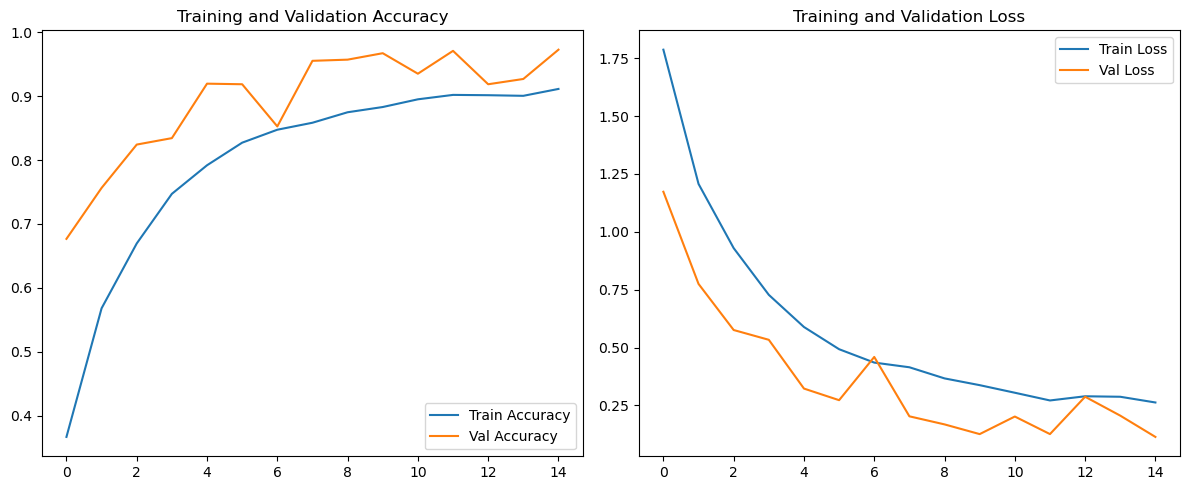

In [48]:
#Plotting Training Curves

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12,5))

    #Accuracy
    plt.subplot(1,2,1)
    plt.plot(epochs_range, acc, label = 'Train Accuracy')
    plt.plot(epochs_range, val_acc, label = 'Val Accuracy')
    plt.legend(loc = 'lower right')
    plt.title('Training and Validation Accuracy')

    #loss
    plt.subplot(1,2,2)
    plt.plot(epochs_range, loss, label = 'Train Loss')
    plt.plot(epochs_range, val_loss, label = 'Val Loss')
    plt.legend(loc = 'upper right')
    plt.title('Training and Validation Loss')

    plt.tight_layout()
    plt.show()

#Call the function
plot_training_history(history)

C:\ProgramData\shail\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 71s 711ms/step

Classification Report:
                                  precision    recall  f1-score   support

                     animal fish       0.98      0.97      0.97       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.98      1.00      0.99       298
   fish sea_food gilt_head_bream       0.99      0.84      0.91       305
   fish sea_food hourse_mackerel       0.98      1.00      0.99       286
        fish sea_food red_mullet       0.99      1.00      0.99       291
     fish sea_food red_sea_bream       0.90      0.97      0.93       273
          fish sea_food sea_bass       0.93      0.97      0.95       327
            fish sea_food shrimp       0.98      0.99      0.98       289
fish sea_food striped_red_mullet       0.98      0.98      0.98       293
             fish sea_food trout       0.98      1.00      0.99       292

                        accuracy          

C:\ProgramData\shail\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\shail\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\shail\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


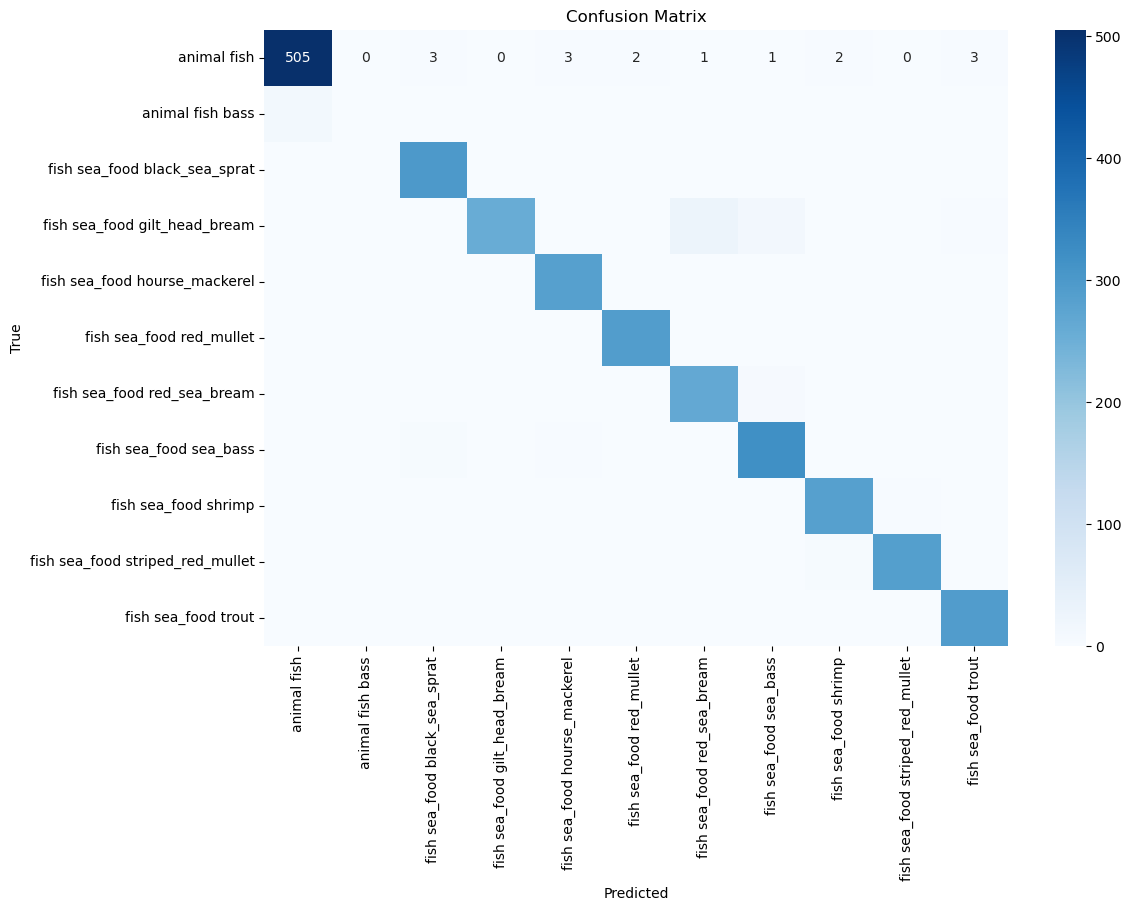

In [52]:
#Evaluate on Test Data

#Step 1: Predict on Test data
y_true = test_gen.classes
y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis = 1)

#Step 2: Get class Labels
class_labels = list(test_gen.class_indices.keys())

#Step 3: Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names = class_labels))

#Step 4: Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize = (12,8))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = class_labels, yticklabels = class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Let's Understand the above 2 steps:

1. Training and Validation Curves:
   - **Accuracy Plot:**
     - Training accuracy steadily increases.
     - Validation accuracy is higher than training and stays high.
     - **Great Result**, the model is generalizing well, not overfitting
   - **Loss Plot:**
     - Both training and validation loss decrease over time.
     - No signs of divergence and instability
     - It can be considered as **Smooth Learning**
     

2. Classification report:
 | Metric        | Meaning                                                                                 |
| ------------- | --------------------------------------------------------------------------------------- |
| **Precision** | Out of all predicted as Class X, how many were actually X? (Low = many false positives) |
| **Recall**    | Out of all actual Class X, how many did the model catch? (Low = many false negatives)   |
| **F1-score**  | Harmonic mean of precision & recall — balances both                                     |
| **Support**   | Number of true samples for that class                                                
3. Most classes have precision/recall greater than 0.95, which is excellent.
4. Example:
   - fish sea_food trout: precision = 0.98, recall = 1.00 -> near perfect
   - black_sea_sprat, shrimp, red_mullet: also excellent
5. **Issue:** animal fish bass
   - Support = 13, precision/recall = 0.00
   - This means the model failed to predict any image as animal fish bass
   - **Cause:** It is underrepresented in training only 30 training images vs. 500+ in other classes.
   - CNNs struggle when one class has very few samples - it gets ignored.
6. **Confusion Matrix:**
   - It confirms what the classification report showed:
   - Diagonal cells = correct predictions (high values -> good)
   - Off-diagonal cells = misclassifications
   - Most predictions are on the diagonal, which is a perfect behaviour
   - A few misclassifications in animal fish, which is expected because it's a broad class.
   - animal fish bass has no diagonal score, which means the model didn't recognize it at all.
  
7. **Summary:**
| Category         | Status                | Notes                                       |
| ---------------- | --------------------- | ------------------------------------------- |
| Overall accuracy | ✅ 97%                 | Excellent                                   |
| Class imbalance  | ⚠️ `animal fish bass` | Too few samples                             |
| Generalization   | ✅ Excellent           | Training vs. validation trends look healthy |
| Overfitting risk | ❌ None                | Losses are aligned                         |
   |
   |


Since our custom CNN is working well with 97.25% accuracy and one class (animal fish bass) is underperforming due to a very low sample count (13 test images, which is approximately 30 train). We should improve performance and compare models that have rich visual features from millions of images, such as VGG16, ResNet60, EfficientNet, MobileNet, and InceptionV3

**We should now proceed with Transfer learning by starting with VGG16**

**VGG16**
- We will load VGG16 without the top i.e. fully connected layers.
- Freeze the pre-trained layers (at first)
- Add custom classifier on top
- Train on our fish dataset
- Save the best model and compare performance

Let's begin with creating a new file vgg16_model.py and then complete the code as per above pointers

In [66]:
from data_loader import create_data_generators

# Define data paths the same as before during CNN
train_path = r"C:\Users\shail_u9zs758\Downloads\Dataset\images.cv_jzk6llhf18tm3k0kyttxz\data\train"
val_path = r"C:\Users\shail_u9zs758\Downloads\Dataset\images.cv_jzk6llhf18tm3k0kyttxz\data\val"
test_path = r"C:\Users\shail_u9zs758\Downloads\Dataset\images.cv_jzk6llhf18tm3k0kyttxz\data\test"

# Load data
train_gen, val_gen, test_gen = create_data_generators(train_path, val_path, test_path)

# Build and train VGG16
vgg_model = build_vgg16_model(input_shape=(224, 224, 3), num_classes=11)
vgg_model, vgg_history = train_vgg16_model(vgg_model, train_gen, val_gen)

Found 6225 images belonging to 11 classes.
Found 1092 images belonging to 11 classes.
Found 3187 images belonging to 11 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


C:\ProgramData\shail\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2912 - loss: 2.0743
Epoch 1: val_accuracy improved from -inf to 0.72802, saving model to vgg16_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 1483s 8s/step - accuracy: 0.2918 - loss: 2.0730 - val_accuracy: 0.7280 - val_loss: 1.3169
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5941 - loss: 1.3178
Epoch 2: val_accuracy improved from 0.72802 to 0.83150, saving model to vgg16_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 1472s 8s/step - accuracy: 0.5943 - loss: 1.3172 - val_accuracy: 0.8315 - val_loss: 0.8666
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7099 - loss: 0.9592
Epoch 3: val_accuracy improved from 0.83150 to 0.87454, saving model to vgg16_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 1464s 8s/step - accuracy: 0.7099 - loss: 0.9589 - val_accuracy: 0.8745 - val_loss: 0.6432
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7442 - loss: 0.8045
Epoch 4: val_accuracy improved from 0.87454 to 0.88553, saving model to vgg16_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 1461s 7s/step - accuracy: 0.7444 - loss: 0.8042 - val_accuracy: 0.8855 - val_loss: 0.5176
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7930 - loss: 0.6597
Epoch 5: val_accuracy improved from 0.88553 to 0.90934, saving model to vgg16_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 1473s 8s/step - accuracy: 0.7931 - loss: 0.6596 - val_accuracy: 0.9093 - val_loss: 0.4126
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8197 - loss: 0.5777
Epoch 6: val_accuracy improved from 0.90934 to 0.92125, saving model to vgg16_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 1454s 7s/step - accuracy: 0.8198 - loss: 0.5776 - val_accuracy: 0.9212 - val_loss: 0.3623
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8436 - loss: 0.5030
Epoch 7: val_accuracy did not improve from 0.92125
195/195 ━━━━━━━━━━━━━━━━━━━━ 1458s 7s/step - accuracy: 0.8436 - loss: 0.5029 - val_accuracy: 0.9112 - val_loss: 0.3312
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8599 - loss: 0.4636
Epoch 8: val_accuracy improved from 0.92125 to 0.93773, saving model to vgg16_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 1458s 7s/step - accuracy: 0.8599 - loss: 0.4635 - val_accuracy: 0.9377 - val_loss: 0.2812
Epoch 9/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8680 - loss: 0.4264
Epoch 9: val_accuracy improved from 0.93773 to 0.94322, saving model to vgg16_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 1458s 7s/step - accuracy: 0.8681 - loss: 0.4264 - val_accuracy: 0.9432 - val_loss: 0.2441
Epoch 10/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8888 - loss: 0.3751
Epoch 10: val_accuracy did not improve from 0.94322
195/195 ━━━━━━━━━━━━━━━━━━━━ 1505s 8s/step - accuracy: 0.8887 - loss: 0.3751 - val_accuracy: 0.9405 - val_loss: 0.2433


In [70]:
#Saving the model with .Keras as well for future proofing
model.save('vgg16_model.keras')

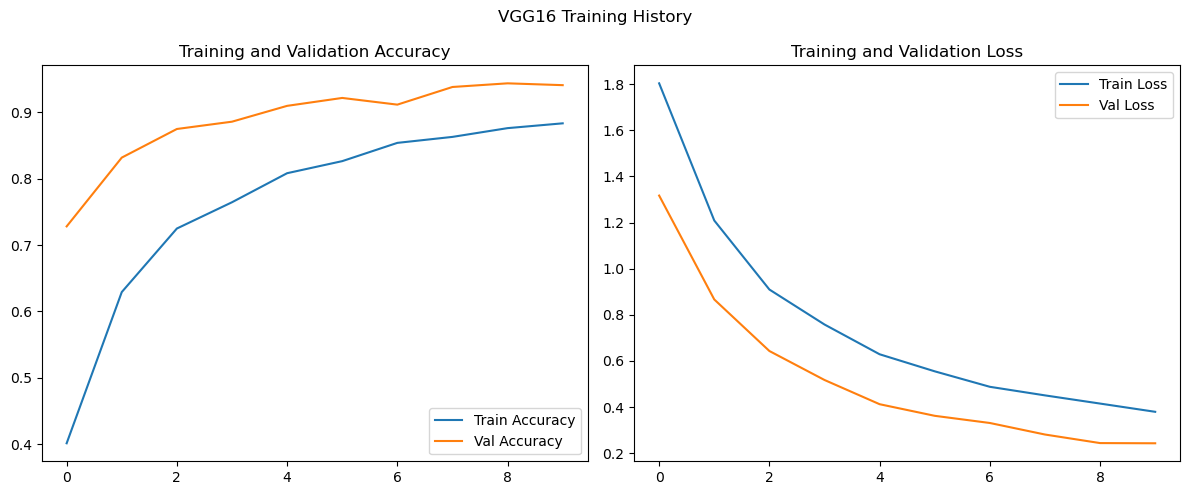

In [76]:
def plot_training_history(history, title="VGG16 Training History"):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend(loc='lower right')

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.legend(loc='upper right')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Call the function
plot_training_history(vgg_history, title="VGG16 Training History")

100/100 ━━━━━━━━━━━━━━━━━━━━ 685s 7s/step
📋 Classification Report:

                                  precision    recall  f1-score   support

                     animal fish       0.97      1.00      0.98       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.96      0.98      0.97       298
   fish sea_food gilt_head_bream       0.94      0.98      0.96       305
   fish sea_food hourse_mackerel       0.95      0.98      0.96       286
        fish sea_food red_mullet       0.94      0.88      0.91       291
     fish sea_food red_sea_bream       0.98      0.93      0.95       273
          fish sea_food sea_bass       0.98      0.97      0.97       327
            fish sea_food shrimp       0.91      1.00      0.95       289
fish sea_food striped_red_mullet       0.89      0.85      0.87       293
             fish sea_food trout       1.00      0.97      0.98       292

                        accuracy          

C:\ProgramData\shail\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\shail\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\shail\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


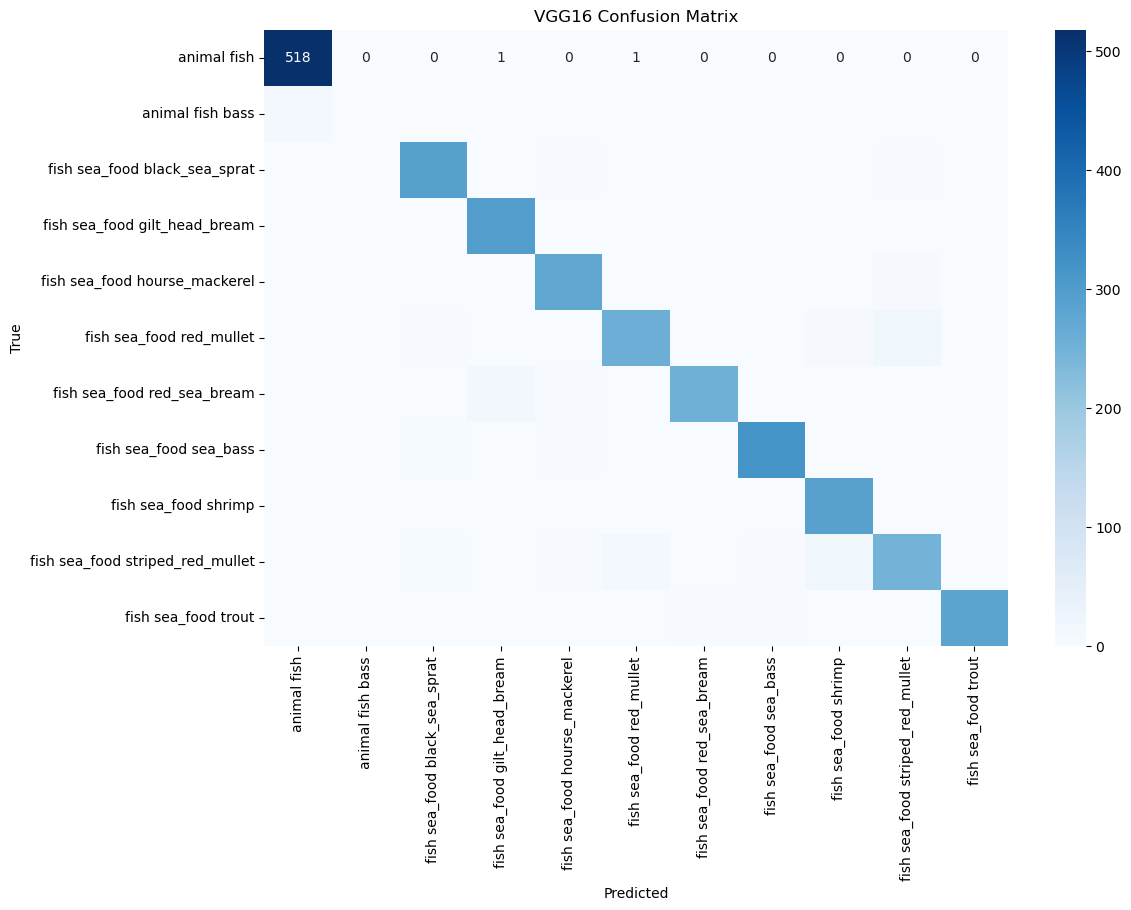

In [78]:
# Predict on test data
y_true = test_gen.classes
y_pred_probs = vgg_model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

# Class labels
class_labels = list(test_gen.class_indices.keys())

# Classification Report
print("📋 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("VGG16 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

**VGG16 Evaluation Breakdown**
1. Overall Accuracy
   - VGG16 Accuracy: 95%
   - Custom CNN Accuracy: 97%
Slightly lower than our customer CNN - surprising but I think not uncommon
This could be because:
    - Custom CNN model suits better for out dataset
    - Transfer learning model is undertrained, we only trained it for 10 epochs against 15 epochs for Customer CNN model.
  
2. Class-wise Performance: animal fish bass
   - Precision/Recall/F1 = 0.00
   - This model failed to detect this class again, just like our Custom CNN
   - Still underrepresented with only 13 test samples

**Low sample size is the key issue and not the model architecture.**

Other class performance:
| Class                | VGG16 F1 | CNN F1    |
| -------------------- | -------- | --------- |
| `animal fish`        | 0.98     | 0.97      |
| `black_sea_sprat`    | 0.97     | 0.99   ❌  |
| `gilt_head_bream`    | 0.96     | 0.9    ✅  |
| `hourse_mackerel`    | 0.96     | 0. 9   ❌  |
| `red_mullet`         | 0.91     | 0 99   ❌  |
| `red_sea_bream`      | 0.95     |  .93   ✅  |
| `sea_bass`           | 0.97     | 0.95   ✅  |
| `shrimp`             | 0.95       0.98   ❌  |
| `striped_red_mullet` | 0.87     | 0.98   ❌  |
| `trout`              | 0.98     | 0
**Summary:**
- VGG16 did well, especially on some class such as gilt_head_bream, sea_bass.
- CNN outperformed VGG16 on several cases, especially those with more training data
- CNN is still ahead but not by much.

**Confusion Matrix:**
- Most classes are predicted very well with diagonal dominance
- Very few misclassifications
- animal fish bass again has no true positives since the model skipped it

**Final Analysis:**
| Aspect                 | Verdict                           |
| ---------------------- | --------------------------------- |
| Overall Accuracy       | ✅ Good (95%)                      |
| Compared to Custom CNN | ❌ Slightly behind (CNN = 97%)     |
| Rare Class Performance | ❌ Still poor (`animal fish bass`) |
| Generalization         | ✅ Excellent                       |
| Useful for Deployment? | ✅ Yes, depending on use case      |
.99   ⚖️ |


**Although both our previous models were Good and ready to deploy, they missed the class animal fish bass, I am going to try another algorithm/model for even better results.** The model that I will try now is **ResNet50**

**Transfer Learning with ResNet50:**

We will same approach as VGG16:
- Create a file name resnet_model.py
- Load the ResNet50 base
- Freeze pretrained layers
- Add a custom classification head
- Train, evaluate and compare

In [84]:
from resnet_model import build_resnet50_model, train_resnet50_model
from data_loader import create_data_generators

# Load data
train_path = r"C:\Users\shail_u9zs758\Downloads\Dataset\images.cv_jzk6llhf18tm3k0kyttxz\data\train"
val_path = r"C:\Users\shail_u9zs758\Downloads\Dataset\images.cv_jzk6llhf18tm3k0kyttxz\data\val"
test_path = r"C:\Users\shail_u9zs758\Downloads\Dataset\images.cv_jzk6llhf18tm3k0kyttxz\data\test"

train_gen, val_gen, test_gen = create_data_generators(train_path, val_path, test_path)

# Build and train ResNet50
resnet_model = build_resnet50_model(input_shape=(224, 224, 3), num_classes=11)
resnet_model, resnet_history = train_resnet50_model(resnet_model, train_gen, val_gen)

Found 6225 images belonging to 11 classes.
Found 1092 images belonging to 11 classes.
Found 3187 images belonging to 11 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


C:\ProgramData\shail\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1285 - loss: 2.4064
Epoch 1: val_accuracy improved from -inf to 0.17125, saving model to resnet50_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 565s 3s/step - accuracy: 0.1286 - loss: 2.4060 - val_accuracy: 0.1712 - val_loss: 2.2541
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1621 - loss: 2.2817
Epoch 2: val_accuracy improved from 0.17125 to 0.17491, saving model to resnet50_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 501s 3s/step - accuracy: 0.1621 - loss: 2.2816 - val_accuracy: 0.1749 - val_loss: 2.1787
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1956 - loss: 2.2027
Epoch 3: val_accuracy improved from 0.17491 to 0.18498, saving model to resnet50_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 486s 2s/step - accuracy: 0.1955 - loss: 2.2027 - val_accuracy: 0.1850 - val_loss: 2.1450
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2094 - loss: 2.1449
Epoch 4: val_accuracy improved from 0.18498 to 0.20604, saving model to resnet50_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 493s 3s/step - accuracy: 0.2094 - loss: 2.1450 - val_accuracy: 0.2060 - val_loss: 2.0787
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2165 - loss: 2.1297
Epoch 5: val_accuracy improved from 0.20604 to 0.23077, saving model to resnet50_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 484s 2s/step - accuracy: 0.2165 - loss: 2.1297 - val_accuracy: 0.2308 - val_loss: 2.0728
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2247 - loss: 2.1038
Epoch 6: val_accuracy improved from 0.23077 to 0.23535, saving model to resnet50_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 483s 2s/step - accuracy: 0.2247 - loss: 2.1039 - val_accuracy: 0.2353 - val_loss: 2.0543
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2350 - loss: 2.0970
Epoch 7: val_accuracy improved from 0.23535 to 0.30495, saving model to resnet50_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 485s 2s/step - accuracy: 0.2350 - loss: 2.0970 - val_accuracy: 0.3049 - val_loss: 2.0021
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2497 - loss: 2.0447
Epoch 8: val_accuracy improved from 0.30495 to 0.31777, saving model to resnet50_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 484s 2s/step - accuracy: 0.2496 - loss: 2.0448 - val_accuracy: 0.3178 - val_loss: 1.9731
Epoch 9/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2417 - loss: 2.0622
Epoch 9: val_accuracy improved from 0.31777 to 0.33608, saving model to resnet50_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 484s 2s/step - accuracy: 0.2418 - loss: 2.0622 - val_accuracy: 0.3361 - val_loss: 1.9742
Epoch 10/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2567 - loss: 2.0313
Epoch 10: val_accuracy did not improve from 0.33608
195/195 ━━━━━━━━━━━━━━━━━━━━ 482s 2s/step - accuracy: 0.2567 - loss: 2.0313 - val_accuracy: 0.2756 - val_loss: 1.9387


In [94]:
#Saving the model with .Keras as well for future proofing
model.save('resnet50_model.keras')

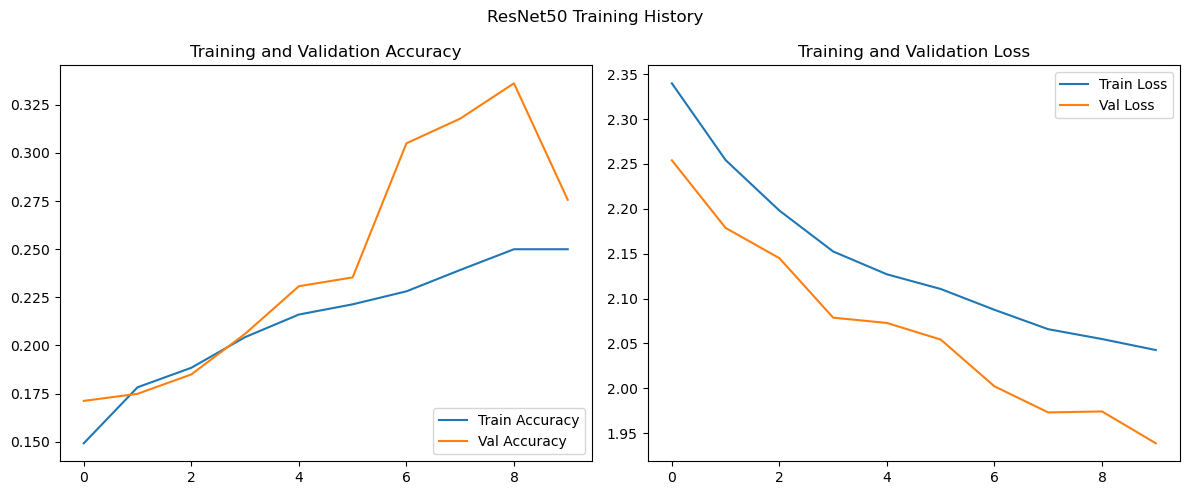

In [88]:
# Lets plot the training/validation accuracy and loss
def plot_training_history(history, title="ResNet50 Training History"):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend(loc='lower right')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.legend(loc='upper right')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Plot for ResNet50
plot_training_history(resnet_history, title="ResNet50 Training History")

100/100 ━━━━━━━━━━━━━━━━━━━━ 216s 2s/step

📋 ResNet50 Classification Report:

                                  precision    recall  f1-score   support

                     animal fish       0.44      0.72      0.55       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.00      0.00      0.00       298
   fish sea_food gilt_head_bream       0.50      0.01      0.01       305
   fish sea_food hourse_mackerel       0.27      0.55      0.36       286
        fish sea_food red_mullet       0.28      0.14      0.19       291
     fish sea_food red_sea_bream       0.25      0.25      0.25       273
          fish sea_food sea_bass       0.00      0.00      0.00       327
            fish sea_food shrimp       0.28      0.46      0.35       289
fish sea_food striped_red_mullet       0.22      0.20      0.21       293
             fish sea_food trout       0.25      0.51      0.33       292

                        accuracy

C:\ProgramData\shail\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\shail\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\shail\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


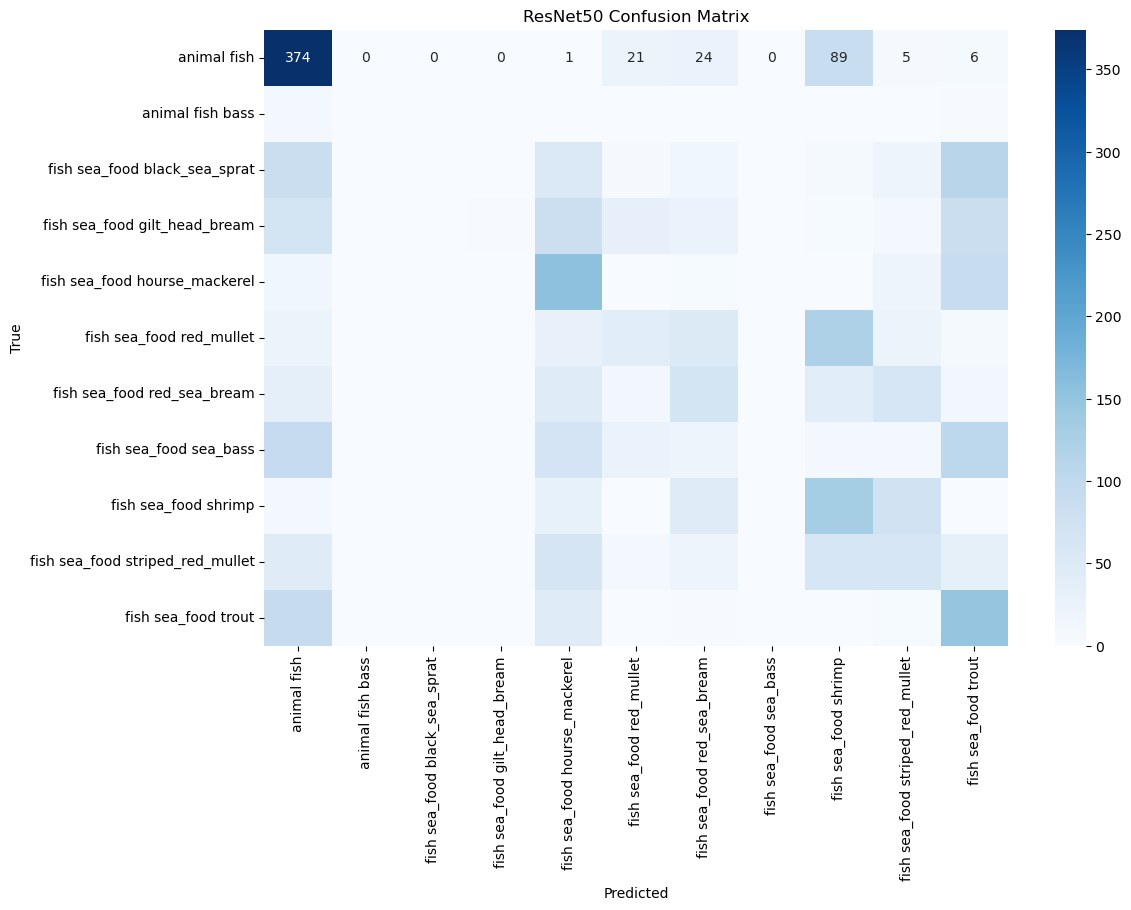

In [90]:
# Predict on test data
y_true = test_gen.classes
y_pred_probs = resnet_model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

# Class labels
class_labels = list(test_gen.class_indices.keys())

# Classification Report
print("\n📋 ResNet50 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("ResNet50 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Lets understand the above visualizations for ResNet50 Model:

The ResNet50 performance is unexpectedly poor, especially compared to your custom CNN and VGG16.

**ResNet50 Results Breakdown:**
- Overall Accuracy: ~31%
- Much lower than:
  - Custom CNN: ~97%
  - VGG16: ~95%
 
**Classification Report:**
| Class              | Precision | Recall | F1   | Notes              |
| ------------------ | --------- | ------ | ---- | ------------------ |
| `animal fish`      | 0.44      | 0.72   | 0.55 | Somewhat OK        |
| `animal fish bass` | 0.00      | 0.00   | 0.00 | ❌ Ignored again    |
| `black_sea_sprat`  | 0.00      | 0.00   | 0.00 | ❌ Total failure    |
| `gilt_head_bream`  | 0.50      | 0.01   | 0.01 | ❌ Massive mismatch |
| `trout`            | 0.25      | 0.51   | 0.33 | Poor precision 
**Confusion Matrix:**
- Predictions are highly scattered, not concentrated on diagonals
- This usually signals:
  - Poor feature learning
  - Incompatible architecture for the dataset we have

Since the performance of this model was unexpectedly poor, We should try another Transfer learning with EfficientNetB0.    |


**Transfer Learning with EfficientNetB0**

In [96]:
#Same as before, we have created a file "efficientnet_model.py" and then created our model for training.
from efficientnet_model import build_efficientnet_model, train_efficientnet_model
from data_loader import create_data_generators

# Load data
train_path = r"C:\Users\shail_u9zs758\Downloads\Dataset\images.cv_jzk6llhf18tm3k0kyttxz\data\train"
val_path = r"C:\Users\shail_u9zs758\Downloads\Dataset\images.cv_jzk6llhf18tm3k0kyttxz\data\val"
test_path = r"C:\Users\shail_u9zs758\Downloads\Dataset\images.cv_jzk6llhf18tm3k0kyttxz\data\test"

train_gen, val_gen, test_gen = create_data_generators(train_path, val_path, test_path)

# Build and train EfficientNetB0
effnet_model = build_efficientnet_model(input_shape=(224, 224, 3), num_classes=11)
effnet_model, effnet_history = train_efficientnet_model(effnet_model, train_gen, val_gen)

Found 6225 images belonging to 11 classes.
Found 1092 images belonging to 11 classes.
Found 3187 images belonging to 11 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


C:\ProgramData\shail\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1433 - loss: 2.3736
Epoch 1: val_accuracy improved from -inf to 0.17125, saving model to efficientnet_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 342s 2s/step - accuracy: 0.1434 - loss: 2.3735 - val_accuracy: 0.1712 - val_loss: 2.3167
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1668 - loss: 2.3273
Epoch 2: val_accuracy did not improve from 0.17125
195/195 ━━━━━━━━━━━━━━━━━━━━ 231s 1s/step - accuracy: 0.1668 - loss: 2.3273 - val_accuracy: 0.1712 - val_loss: 2.3122
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1770 - loss: 2.3128
Epoch 3: val_accuracy did not improve from 0.17125
195/195 ━━━━━━━━━━━━━━━━━━━━ 250s 1s/step - accuracy: 0.1770 - loss: 2.3128 - val_accuracy: 0.1712 - val_loss: 2.3124
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1681 - loss: 2.3176
Epoch 4: val_accuracy did not improve from 0.17125
195/195 ━━━━━━━━━━━━━━━━━━━━ 286s 1s/step - accuracy: 0.1681 - loss: 2.3175 - val_accuracy: 0.1712 - val_loss: 2.3104
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1757 - loss: 2.3121
Epoch 5: val_accuracy did not impro

In [101]:
# Since there is no improvement for 5 epochs in the val_accuracy, the model stopped training early.

100/100 ━━━━━━━━━━━━━━━━━━━━ 91s 870ms/step


C:\ProgramData\shail\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\shail\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\shail\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                  precision    recall  f1-score   support

                     animal fish       0.16      1.00      0.28       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.00      0.00      0.00       298
   fish sea_food gilt_head_bream       0.00      0.00      0.00       305
   fish sea_food hourse_mackerel       0.00      0.00      0.00       286
        fish sea_food red_mullet       0.00      0.00      0.00       291
     fish sea_food red_sea_bream       0.00      0.00      0.00       273
          fish sea_food sea_bass       0.00      0.00      0.00       327
            fish sea_food shrimp       0.00      0.00      0.00       289
fish sea_food striped_red_mullet       0.00      0.00      0.00       293
             fish sea_food trout       0.00      0.00      0.00       292

                        accuracy                           0.16      3187
                       macro avg    

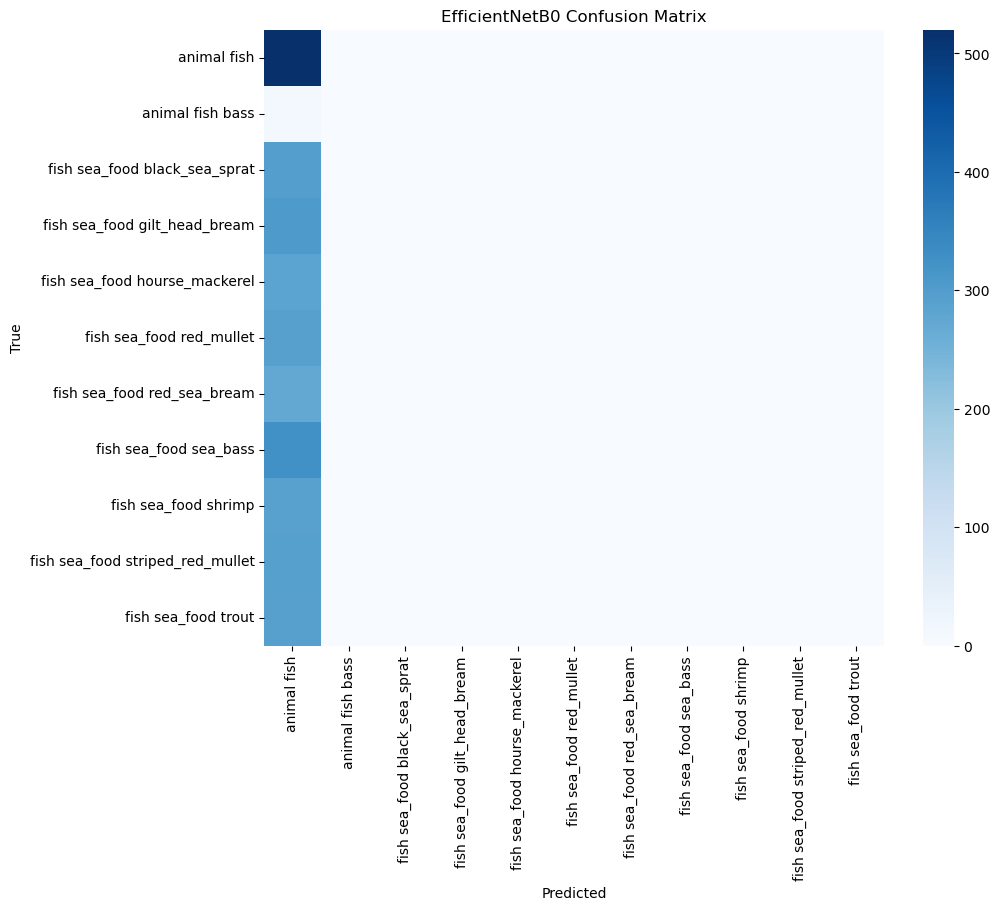

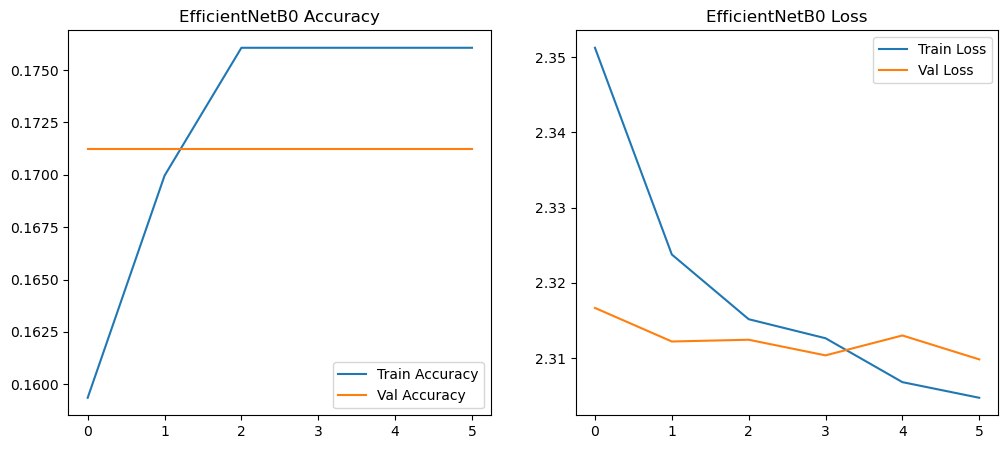

In [103]:
#trying to code all at once

# Predict on test data
preds = effnet_model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
y_true = test_gen.classes

# Report
print(classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys()))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
plt.title("EfficientNetB0 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Plot
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(effnet_history.history['accuracy'], label='Train Accuracy')
plt.plot(effnet_history.history['val_accuracy'], label='Val Accuracy')
plt.title('EfficientNetB0 Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(effnet_history.history['loss'], label='Train Loss')
plt.plot(effnet_history.history['val_loss'], label='Val Loss')
plt.title('EfficientNetB0 Loss')
plt.legend()

plt.show()

**EfficientNetB0 Results Summary:**
- Accuracy and Loss Plots:
- Train Accuracy: Barely reaches 17.6%
- Val Accuracy: Flat at ~17.1%
- Loss: Only slight decrease, plateauing early

**Confusion Matrix:**
The model predicts almost every class as "animal fish".
All other classes have zero meaningful predictions.

**Classification Report:**
| Class       | Precision | Recall | F1-score |
| ----------- | --------- | ------ | -------- |
| animal fish | 0.16      | 1.00   | 0.28     |
| all others  | 0.00      | 0.00   | 0.00    

**Interpretation:**
EfficientNetB0 failed to learn the actual class features. It defaulted to the majority class ("animal fish") for all predictions. This is a clear case of class imbalance sensitivity or ineffective transfer from the pre-trained weights. |


**Transfer Learning using DenseNet121**

# Step-by-Step Plan for DenseNet121
We’ll follow the same pipeline:
- Load the base DenseNet121 model
- Freeze the base layers (use pretrained ImageNet weights)
- Add custom classification head
- Compile & train the model
- **Evaluate using:**
- Confusion matrix
- Classification report
- Accuracy/loss plots

In [111]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# ===== STEP 1: Build the model =====
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(11, activation='softmax')(x)  # 11 classes

model = Model(inputs=base_model.input, outputs=predictions)

# ===== STEP 2: Compile the model =====
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ===== STEP 3: Set up callbacks =====
checkpoint_cb = ModelCheckpoint('densenet_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystop_cb = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# ===== STEP 4: Train the model =====
history_densenet = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=[checkpoint_cb, earlystop_cb]
)


Epoch 1/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1531 - loss: 3.2949
Epoch 1: val_accuracy improved from -inf to 0.64377, saving model to densenet_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 520s 3s/step - accuracy: 0.1534 - loss: 3.2922 - val_accuracy: 0.6438 - val_loss: 1.5857
Epoch 2/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3422 - loss: 1.9543
Epoch 2: val_accuracy improved from 0.64377 to 0.82051, saving model to densenet_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 466s 2s/step - accuracy: 0.3424 - loss: 1.9537 - val_accuracy: 0.8205 - val_loss: 1.1800
Epoch 3/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4714 - loss: 1.5673
Epoch 3: val_accuracy improved from 0.82051 to 0.88645, saving model to densenet_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 505s 2s/step - accuracy: 0.4715 - loss: 1.5669 - val_accuracy: 0.8864 - val_loss: 0.8776
Epoch 4/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5594 - loss: 1.2925
Epoch 4: val_accuracy improved from 0.88645 to 0.92491, saving model to densenet_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 468s 2s/step - accuracy: 0.5595 - loss: 1.2923 - val_accuracy: 0.9249 - val_loss: 0.6382
Epoch 5/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6230 - loss: 1.1264
Epoch 5: val_accuracy improved from 0.92491 to 0.94414, saving model to densenet_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 467s 2s/step - accuracy: 0.6231 - loss: 1.1262 - val_accuracy: 0.9441 - val_loss: 0.4905
Epoch 6/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6666 - loss: 0.9947
Epoch 6: val_accuracy improved from 0.94414 to 0.95513, saving model to densenet_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 464s 2s/step - accuracy: 0.6666 - loss: 0.9946 - val_accuracy: 0.9551 - val_loss: 0.4039
Epoch 7/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6865 - loss: 0.9043
Epoch 7: val_accuracy improved from 0.95513 to 0.95879, saving model to densenet_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 468s 2s/step - accuracy: 0.6866 - loss: 0.9041 - val_accuracy: 0.9588 - val_loss: 0.3410
Epoch 8/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7217 - loss: 0.8045
Epoch 8: val_accuracy improved from 0.95879 to 0.96062, saving model to densenet_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 465s 2s/step - accuracy: 0.7217 - loss: 0.8045 - val_accuracy: 0.9606 - val_loss: 0.3028
Epoch 9/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7285 - loss: 0.7739
Epoch 9: val_accuracy improved from 0.96062 to 0.96612, saving model to densenet_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 473s 2s/step - accuracy: 0.7286 - loss: 0.7737 - val_accuracy: 0.9661 - val_loss: 0.2585
Epoch 10/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7688 - loss: 0.6748
Epoch 10: val_accuracy improved from 0.96612 to 0.96886, saving model to densenet_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 466s 2s/step - accuracy: 0.7688 - loss: 0.6748 - val_accuracy: 0.9689 - val_loss: 0.2269
Epoch 11/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7766 - loss: 0.6701
Epoch 11: val_accuracy improved from 0.96886 to 0.97161, saving model to densenet_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 506s 2s/step - accuracy: 0.7766 - loss: 0.6701 - val_accuracy: 0.9716 - val_loss: 0.2009
Epoch 12/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7904 - loss: 0.6109
Epoch 12: val_accuracy improved from 0.97161 to 0.97436, saving model to densenet_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 477s 2s/step - accuracy: 0.7904 - loss: 0.6109 - val_accuracy: 0.9744 - val_loss: 0.1802
Epoch 13/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7840 - loss: 0.5963
Epoch 13: val_accuracy improved from 0.97436 to 0.97619, saving model to densenet_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 529s 3s/step - accuracy: 0.7841 - loss: 0.5962 - val_accuracy: 0.9762 - val_loss: 0.1665
Epoch 14/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8065 - loss: 0.5709
Epoch 14: val_accuracy improved from 0.97619 to 0.97802, saving model to densenet_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 767s 4s/step - accuracy: 0.8065 - loss: 0.5709 - val_accuracy: 0.9780 - val_loss: 0.1523
Epoch 15/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8206 - loss: 0.5313
Epoch 15: val_accuracy did not improve from 0.97802
195/195 ━━━━━━━━━━━━━━━━━━━━ 776s 4s/step - accuracy: 0.8207 - loss: 0.5312 - val_accuracy: 0.9771 - val_loss: 0.1437


In [113]:
#Seems like this model has performed better than our Custom CNN model. Lets evaluate and confirm if this is true.

100/100 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step
📋 Classification Report:

                                  precision    recall  f1-score   support

                     animal fish       0.98      0.99      0.98       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.99      1.00      0.99       298
   fish sea_food gilt_head_bream       0.96      0.96      0.96       305
   fish sea_food hourse_mackerel       1.00      0.99      0.99       286
        fish sea_food red_mullet       1.00      0.99      0.99       291
     fish sea_food red_sea_bream       0.97      0.99      0.98       273
          fish sea_food sea_bass       0.98      0.98      0.98       327
            fish sea_food shrimp       0.99      1.00      0.99       289
fish sea_food striped_red_mullet       0.98      1.00      0.99       293
             fish sea_food trout       1.00      0.98      0.99       292

                        accuracy          

C:\ProgramData\shail\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\shail\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\shail\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


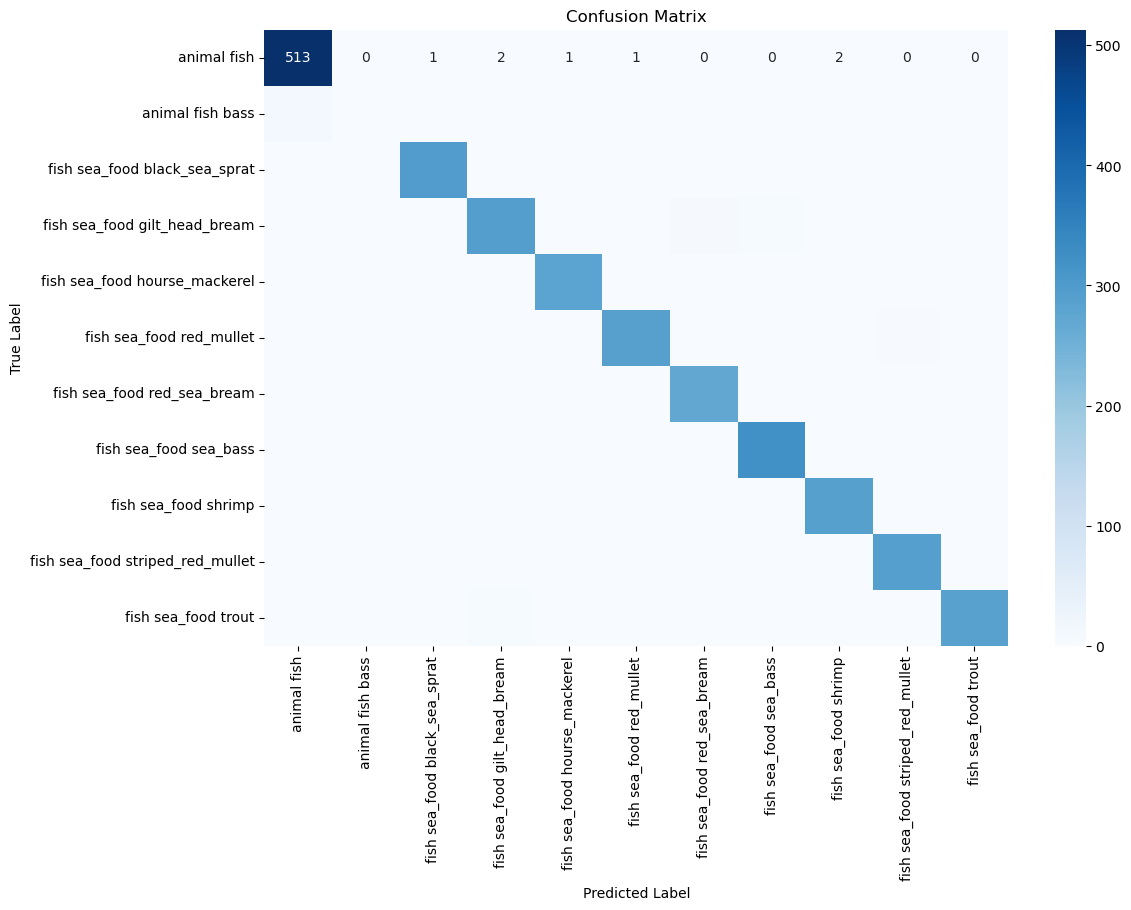

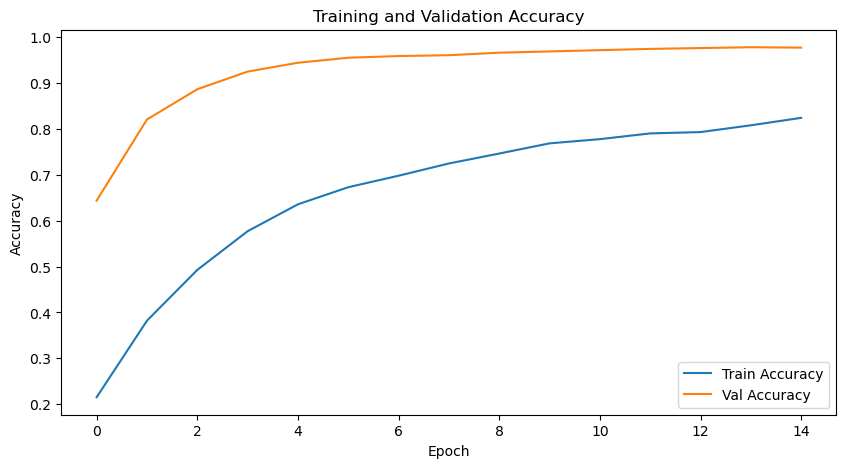

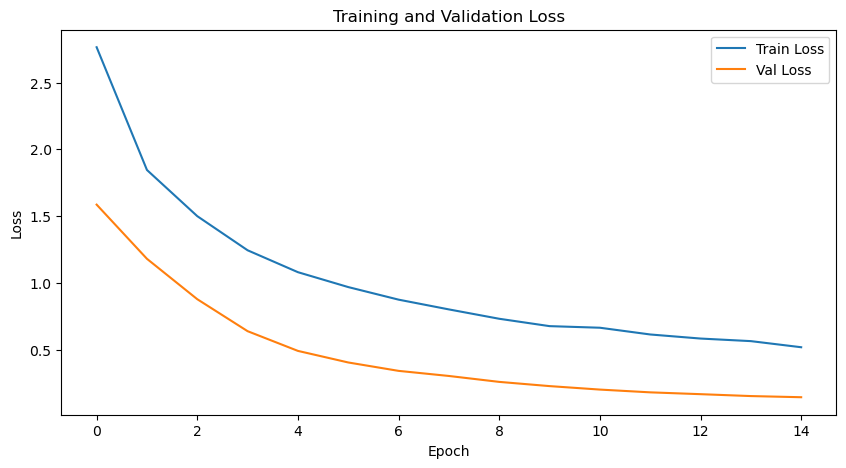

In [121]:
# Get predictions
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels
y_true = test_gen.classes

# Label mapping
class_labels = list(test_gen.class_indices.keys())

# Classification Report
print("📋 Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

#Lets also visualize the Accuracy/Validation loss

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(history_densenet.history['accuracy'], label='Train Accuracy')
plt.plot(history_densenet.history['val_accuracy'], label='Val Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(history_densenet.history['loss'], label='Train Loss')
plt.plot(history_densenet.history['val_loss'], label='Val Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Evaluating DenseNetB0 summary:**

| Metric                             | Value                         |
| ---------------------------------- | ----------------------------- |
| **Overall Accuracy**               | **0.98**                      |
| **Worst Class (animal fish bass)** | Precision: 0.00, Recall: 0.00 |
| **Best Performing Classes**        | Many with F1-Score \~**0.99*

**Observations:**
- Clear and sharp diagonal -> Very high accuracy.
- No significant misclassifications, except "animal fish bass" which again got neglected. (This class has very few samples: only 13)

**Accuracy/Loss curves:**
- Training accuracy steadily increases.
- Validation accuracy is high and stabilizes -> No overfitting.
- Loss consistently decreases for both sets -> Healthy learning.

**Classification Report:**
- Almost all classes have precision, recall, f1-score > 0.95.
- Exception: animal fish bass — likely due to class imbalance (too few examples to learn from).* |


**Now that we have trained and evaluated multiple models (Custom built CNN, VGG16, ResNet50, EfficientNetB0 and DenseNet121)**

**Lets compare and summarize all the models and decide which one is the best and ready for deployment for our Streamlit app.**

**Model Comparision Table:**

| **Model**          | **Accuracy** | **Precision / Recall (General)** | **Rare Class Performance**             | **Training Stability** | **Notes**                                                  |
| ------------------ | ------------ | -------------------------------- | -------------------------------------- | ---------------------- | ---------------------------------------------------------- |
| **Custom CNN**     | \~97%        | High                             | Weak for `animal fish bass`            | Stable                 | Strong baseline; good generalization                       |
| **VGG16**          | \~95%        | High                             | Still weak on rare class               | Stable                 | Good performance, but slightly below baseline              |
| **ResNet50**       | \~31%        | Very Low                         | Poor across all classes                | Underfit               | Failed to learn effectively                                |
| **EfficientNetB0** | \~16%        | Very Low                         | Predicted only 1 class                 | Underfit / Flat curves | Did not generalize; stuck early in training                |
| **DenseNet121 ✅**  | **98%**      | **Very High**                    | Better than others (except rare class) | Very Stable            | **Best model** – Excellent across most classes and metrics |


**Current Status:**
- DenseNet121 gives 98% accuracy, with strong generalization.
- Most classes, including tricky fish types, are predicted very well.
- Only one class — animal fish bass (13 samples) — is poorly predicted due to insufficient training data.

**Summarization of the project:**



This project aims to classify fish species from images using Convolutional Neural Networks (CNN) and transfer learning.

Key Steps:
- 📁 Dataset exploration: 11 fish species, split into train/val/test
- 🧪 Base model: Custom CNN (achieved ~97% accuracy)
- 🔁 Transfer Learning: Tested VGG16, ResNet50, EfficientNetB0, DenseNet121
- ✅ Best Model: DenseNet121 with ~98% test (Used in deployment) accuracy
- ⚖️ Observations: One class (‘animal fish bass’) had very few images, resulting in lower accuracy
- 🖥️ Deployment: Streamlit-based web app for real-time predictions

Outcome:
✔️ High-performing model with real-world applicability  
✔️ Clean UI for non-technical users via Streamlit  
✔️ Full workflow from data loading → training → evaluation → deployment

Authohailesh Jangam
"""
